In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import math
from scipy.io import wavfile
from scipy import signal
import os
import glob
import re
import mglearn

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### read wave file

In [12]:
filename = r'C:\Python_Project\SpeechRecognition\savee_data\AudioData\DC\sa12.wav'
sampFreq, speech_data = wavfile.read(filename)

(44100, 16749, 32768.0)

In [7]:
f = wave.open(filename, 'rb')
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
nchannels, sampwidth, framerate, nframes, _, _ = f.getparams()
f.close()
nchannels, sampwidth, framerate, nframes

(1, 2, 44100, 237142)

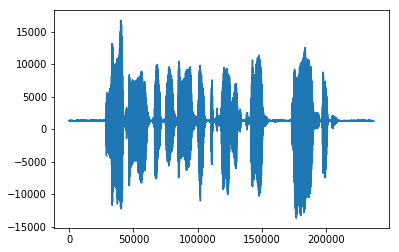

In [8]:
plt.plot(speech_data)

### normalization

(0.511138916015625, -0.4168701171875)

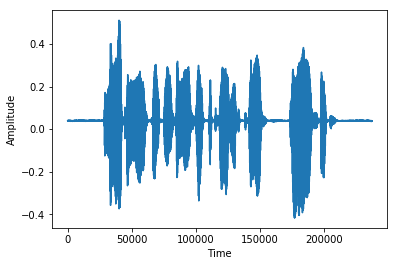

In [13]:
def normalization(speech_data):
    return speech_data /(2.** (sampwidth * 8 - 1))

speech_data = normalization(speech_data)
plt.plot(speech_data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
max(speech_data), min(speech_data)

### enframing

In [9]:
def enframing(speech_data, framerate):
    framesize = int(framerate * 30/1000) #number of frames within 30 ms. 
    framestep = int(framesize/2)
    num = len(speech_data)
    fn = math.ceil((num - framesize)/framestep + 1) # how many steps we need to iterate all frames
#     print(fn)
    speech_enframe = np.zeros(shape=(framesize, fn))
    x_hamming = signal.hamming(framesize)
#     print(f"hamming shape {x_hamming.shape} ")
    for i in range(fn):
        matrix_trans = np.zeros(shape=(framesize))        
        # how to append an array to the length of the framesize
        matrix_trans[:len(speech_data[(i*framestep):(framesize + i*framestep)])] = speech_data[(i*framestep):(framesize + i*framestep)]
#         print(f"matrix shape {matrix_trans.shape}")
        matrix_trans *= x_hamming
#         print(f"matrix*hamming shape {matrix_trans.shape}")
        speech_enframe[:,i] = matrix_trans
    return speech_enframe

In [10]:
enframed_data = enframing(speech_data, framerate)

### short time energy

In [11]:
def stenergy(enframed_data):    
    return np.sum(enframed_data**2, axis=0)
# stenergy = stenergy(enframed_data)
# stenergy

### read all wav data in saveedata folder

In [34]:
path1 = 'C:\Python_Project\SpeechRecognition\savee_data\AudioData\DC'
path2 = 'C:\Python_Project\SpeechRecognition\savee_data\AudioData\JE'
path3 = 'C:\Python_Project\SpeechRecognition\savee_data\AudioData\JK'
path4 = 'C:\Python_Project\SpeechRecognition\savee_data\AudioData\KL'
paths = [path1, path2, path3, path4]

ste = []
class_mark = []
for path in paths:
    for filename in glob.glob(os.path.join(path, '*.wav')):    
        basename = os.path.basename(filename)
        class_mark.append(re.split('\d+', basename)[0])
    
        sampFreq, speech_data = wavfile.read(filename)    
        f = wave.open(filename, 'rb')   
        nchannels, sampwidth, framerate, nframes, _, _ = f.getparams()
        f.close()   
        speech_data = normalization(speech_data)
        enframed = enframing(speech_data, framerate)
        ste.append(stenergy(enframed))

length_ste = []
for itemlist in ste: 
    length_ste.append(len(itemlist))

data_savee = np.zeros((len(ste), max(length_ste))) # shape = (file_nums, the number of frames the longest file has)
for i in range(len(ste)):    
    data_savee[i, :len(ste[i])] = ste[i]
    
dataset = {}
dataset['data'] = data_savee
dataset['target'] = class_mark

(480, 476)


### save dataset to file

In [13]:
np.save('dataset_short_time_energy.npy', dataset)

### split data in train and test set

In [149]:
X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], test_size=0.1, random_state=42)

## classification with svm

In [105]:
clf = SVC(gamma=0.001, C=100. )
clf = clf.fit(X_train, y_train)
# how can i access dictionary keys with dot like dataset.data?

In [106]:
predict_result = clf.predict(X_test)
predict_result

array(['n', 'a', 'f', 'n', 'su', 'n', 'n', 'n', 'a', 'n', 'n', 'n', 'n',
       'n', 'n', 'n', 'n', 'n', 'n', 'h', 'n', 'n', 'n', 'n', 'n', 'h',
       'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'f',
       'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n'],
      dtype='<U2')

In [107]:
assert len(y_test) == len(predict_result)

In [108]:
zip_target = list(zip(predict_result, y_test))

In [109]:
boolean_num = 0
for x, y in zip_target: 
    if x == y:
        boolean_num += 1
accurate_rate = boolean_num / len(y_test)
accurate_rate

0.2916666666666667

In [129]:
score = clf.score(X_test, y_test)
score

0.29166666666666669

In [128]:
from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))

Accuracy: 0.292


In [111]:
cross_val_score(clf, dataset['data'], dataset['target'], cv=10).mean()

0.21875

In [112]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predict_result)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[ 0  0  0  0  3  0  0]
 [ 0  0  0  0  6  0  0]
 [ 0  0  1  0  6  0  1]
 [ 1  0  0  0  4  0  0]
 [ 1  0  0  1 13  0  0]
 [ 0  0  0  0  6  0  0]
 [ 0  0  1  1  3  0  0]]


In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          a       0.00      0.00      0.00         3
          d       0.00      0.00      0.00         6
          f       0.50      0.12      0.20         8
          h       0.00      0.00      0.00         5
          n       0.32      0.87      0.46        15
         sa       0.00      0.00      0.00         6
         su       0.00      0.00      0.00         5

avg / total       0.18      0.29      0.18        48



c:\anaconda3\envs\speechrecognition\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [142]:
from sklearn.metrics import f1_score
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.292
Macro average f1 score: 0.095


c:\anaconda3\envs\speechrecognition\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### random search and cross validation with svm

In [143]:
best_score = 0
ite_num = 50
for i in range(ite_num):
    gamma = 10 **(-4 + (6 * np.random.rand())) # range from 10**-4 to 10**2
    C = 10 **(-4 + (6 * np.random.rand()))
    svm = SVC(gamma=gamma, C=C, kernel='rbf')
    scores = cross_val_score(svm, X_train, y_train, cv=5)
    score =np.mean(scores)
    if score > best_score:
        best_score = score
        best_parameters = {'C': C, 'gamma': gamma}
print(best_parameters)
svm = SVC(**best_parameters)
clf = svm.fit(X_train, y_train)
print(best_score)

{'C': 30.13853969817405, 'gamma': 0.00030830895285700974}
0.282457465016


In [147]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          a       0.00      0.00      0.00         3
          d       0.00      0.00      0.00         6
          f       0.50      0.12      0.20         8
          h       0.00      0.00      0.00         5
          n       0.32      0.87      0.46        15
         sa       0.00      0.00      0.00         6
         su       0.00      0.00      0.00         5

avg / total       0.18      0.29      0.18        48



c:\anaconda3\envs\speechrecognition\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### classification with decision tree

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree = tree.fit(X_train, y_train)

In [61]:
tree.score(X_train, y_train)

0.44907407407407407

In [62]:
tree.score(X_test, y_test) # decision tree has a problem with overfitting

0.3125

In [76]:
cross_val_score(tree, dataset['data'], dataset['target'], cv=10).mean()

0.30625000000000002

### classification with random forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=92, random_state=2)
random_forest = random_forest.fit(X_train, y_train)

In [64]:
random_forest.predict(X_test)

array(['n', 'd', 'a', 'sa', 'd', 'h', 'sa', 'n', 'n', 'n', 'h', 'h', 'n',
       'a', 'su', 'sa', 'sa', 'n', 'a', 'n', 'n', 'n', 'n', 'a', 'sa', 'a',
       'f', 'n', 'd', 'd', 'h', 'h', 'n', 'sa', 'sa', 'd', 'h', 'su', 'a',
       'n', 'd', 'n', 'd', 'sa', 'a', 'n', 'sa', 'n'],
      dtype='<U2')

In [65]:
random_forest.score(X_test, y_test)

0.35416666666666669

In [74]:
cross_val_score(random_forest, dataset['data'], dataset['target'], cv=10).mean()

0.34166666666666667

### classification with KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [67]:
knn = KNeighborsClassifier(n_neighbors=1)
knn = knn.fit(X_train, y_train)

In [68]:
knn.predict(X_test)
knn.score(X_test, y_test)

0.35416666666666669

In [79]:
cross_val_score(knn, dataset['data'], dataset['target'], cv=10).mean()

0.33333333333333331

c:\anaconda3\envs\speechrecognition\lib\site-packages\matplotlib\pyplot.py:2669: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  ret = ax.barh(*args, **kwargs)


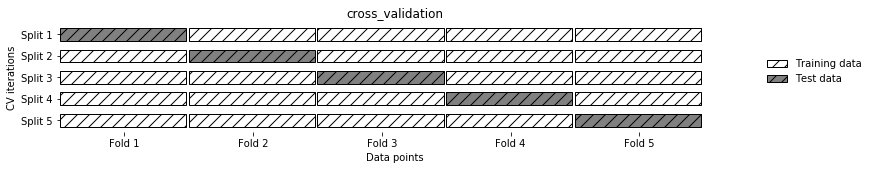

In [3]:
mglearn.plots.plot_cross_validation()

In [4]:
import sys

In [6]:
sys.version

'3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]'